In [61]:
import os
from collections import OrderedDict

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, scale

# from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene


def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax


fsize = 15

base_figure_path = "figures"

alpha = 0.33

import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [63]:
mtx_labels = ["raw", "pf", "log", "pf_log", "pf_log_pf", "cpm_log", "cp10k_log", "sqrt"]
# labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']

labels = [
    "raw",
    "PF",
    "sqrt",
    "log1p",
    "log1pCP10k",
    "log1pCPM",
    "scalelog1pCP10k",
    "sctransform",
    "log1pPF",
    "PFlog1pPF",
]

txlabel = {
    "raw": "raw",
    "pf": "PF",
    "sqrt": "sqrt",
    "log": "log1p",
    "cp10k_log": "log1pCP10k",
    "cpm_log": "log1pCPM",
    "cp10k_log_scale": "scalelog1pCP10k",
    "sctransform": "sctransform",
    "pf_log": "log1pPF",
    "pf_log_pf": "PFlog1pPF",
    "sctransform_cc": "sctransform_cc",
}


def read_data(base_data_fn):
    data = {}

    for title in mtx_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx.gz")
        data[txlabel[title]] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values
    return data

In [41]:
def read_data(base_data_fn):
    data = {}

    for title in read_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx.gz")
        data[title] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[title] = pd.read_csv(in_fn, header=None, compression="gzip").values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[title] = pd.read_csv(in_fn, header=None, compression="gzip").values
    return data

In [66]:
ds = "angelidis_2019"
out_prefix = os.path.join("synchromesh/data/", ds)

In [67]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform
loading cp10k_log_scale
CPU times: user 12min 4s, sys: 58.9 s, total: 13min 3s
Wall time: 13min 11s


In [68]:
bcs = pd.read_csv(
    os.path.join(out_prefix, "metadata_barcodes.txt.gz"),
    compression="gzip",
    index_col=0,
)
assignments = bcs.celltype.values

genes = pd.read_csv(
    os.path.join(out_prefix, "raw_genes.txt.gz"), compression="gzip", header=None
).values.ravel()

In [77]:
def plot_markers(matrix, title, ct, gene, ct_mask, gene_mask, downsample_idx, ax):
    p = {
        "xlabel": "Gene counts",
        "ylabel": f"Frequency ($\it{{{gene}}}$)",
        "title": title,
    }
    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    bins = np.histogram(np.hstack((t, c)), bins=10)[1]  # get the bin edges
    ax.hist(t, label=ct, alpha=0.5, bins=bins, edgecolor="k", facecolor="orange")
    ax.hist(
        c, label="Complement", alpha=0.5, bins=bins, edgecolor="k", facecolor="grey"
    )

    ax.set(**p)
    ax.legend(prop={"size": 11})
    return ax

In [70]:
data["raw"].shape == (assignments.shape[0], genes.shape[0])

True

### Sftpc in Type 2 Pneumocytes



In [71]:
celltype = "Type_2_pneumocytes"
gene = "Sftpc"

gene_mask = genes == gene
ct_mask = assignments == celltype
size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

ks = {}
for title, matrix in data.items():
    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    ks[title] = stats.ks_2samp(t, c)

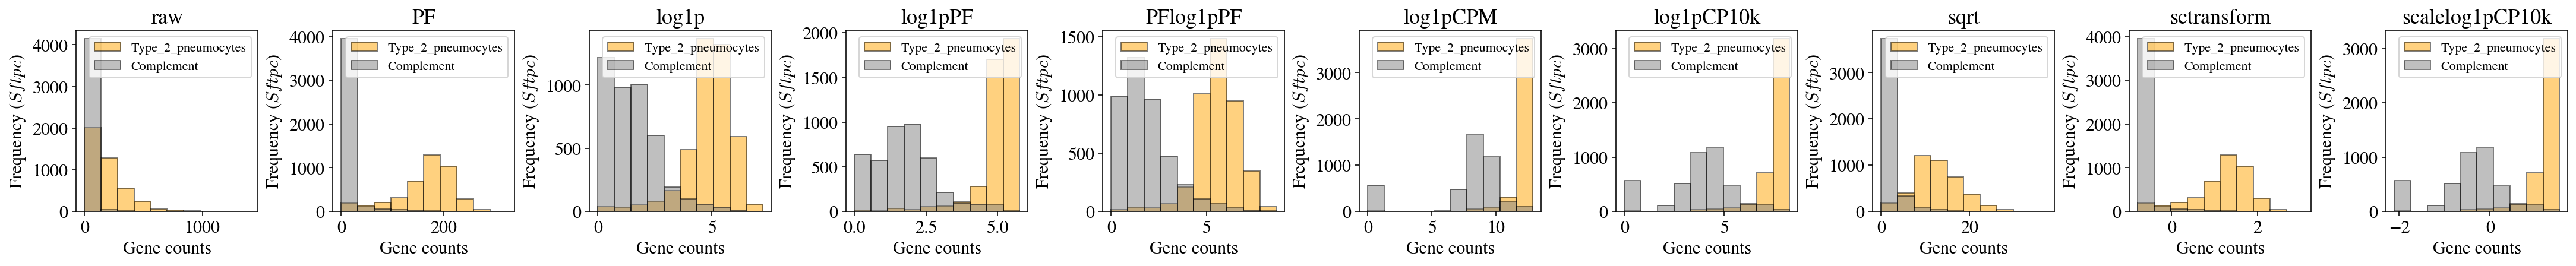

In [78]:
n = len(data.items())
fig, axs = plt.subplots(figsize=(3 * n, 3), ncols=n, constrained_layout=True)

for ax, (k, m) in zip(axs, data.items()):
    plot_markers(m, k, celltype, gene, ct_mask, gene_mask, downsample_idx, ax)

fig.show()

In [51]:
ks

{'raw': KstestResult(statistic=0.8690164324839248, pvalue=0.0),
 'pf': KstestResult(statistic=0.8968802095737081, pvalue=0.0),
 'log': KstestResult(statistic=0.8690164324839248, pvalue=0.0),
 'pf_log': KstestResult(statistic=0.8968802095737081, pvalue=0.0),
 'pf_log_pf': KstestResult(statistic=0.8704453441295547, pvalue=0.0),
 'cpm_log': KstestResult(statistic=0.8968802095737081, pvalue=0.0),
 'cp10k_log': KstestResult(statistic=0.8968802095737081, pvalue=0.0),
 'sqrt': KstestResult(statistic=0.8690164324839248, pvalue=0.0),
 'sctransform': KstestResult(statistic=0.8968802095737081, pvalue=0.0),
 'cp10k_log_scale': KstestResult(statistic=0.8968802095737081, pvalue=0.0)}

### Scgb1a1 in Club and Goblet cells

In [82]:
celltype1 = "Goblet_cells"
celltype2 = "Club_cells"

ct_mask1 = assignments == celltype1
ct_mask2 = assignments == celltype2

ct_mask = np.logical_or(ct_mask1, ct_mask2)

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

gene = "Scgb1a1"

gene_mask = genes == gene

ks = {}
for title, matrix in data.items():
    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    ks[title] = stats.ks_2samp(t, c)

In [83]:
ks

{'raw': KstestResult(statistic=0.8805687203791469, pvalue=0.0),
 'PF': KstestResult(statistic=0.8938388625592417, pvalue=0.0),
 'log1p': KstestResult(statistic=0.8805687203791469, pvalue=0.0),
 'log1pPF': KstestResult(statistic=0.8938388625592417, pvalue=0.0),
 'PFlog1pPF': KstestResult(statistic=0.8568720379146919, pvalue=0.0),
 'log1pCPM': KstestResult(statistic=0.8938388625592417, pvalue=0.0),
 'log1pCP10k': KstestResult(statistic=0.8938388625592417, pvalue=0.0),
 'sqrt': KstestResult(statistic=0.8805687203791469, pvalue=0.0),
 'sctransform': KstestResult(statistic=0.8938388625592417, pvalue=0.0),
 'scalelog1pCP10k': KstestResult(statistic=0.8938388625592417, pvalue=0.0)}

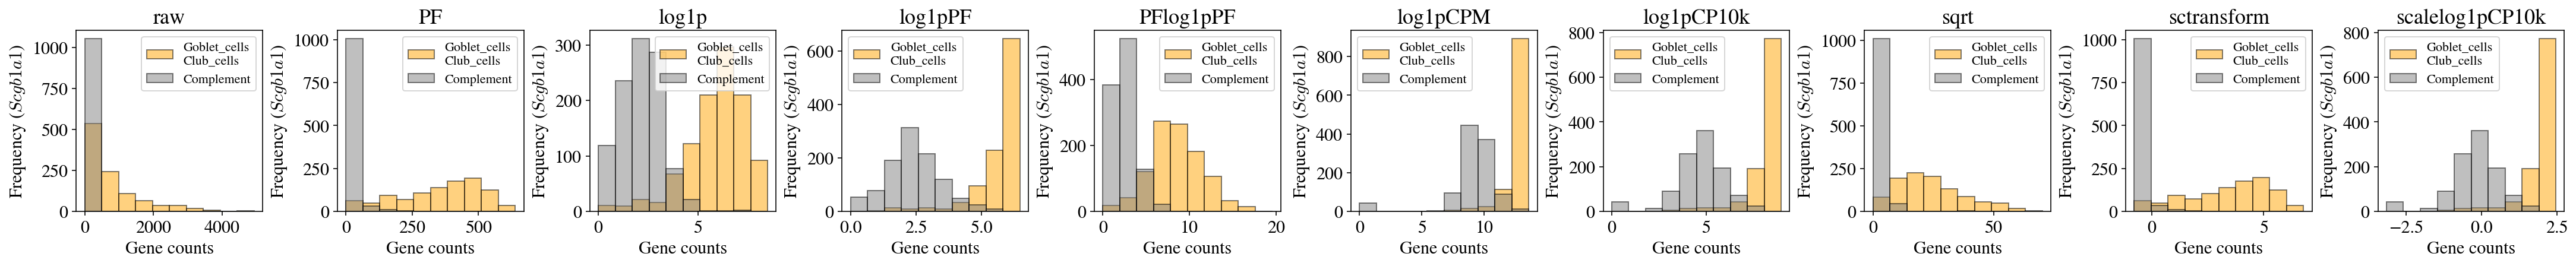

In [84]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(3 * n, 3), ncols=n, constrained_layout=True)

for ax, (k, m) in zip(axs, data.items()):
    plot_markers(
        m, k, celltype1 + "\n" + celltype2, gene, ct_mask, gene_mask, downsample_idx, ax
    )

fig.show()

### Ear2 in Alveolar Macrophages

In [85]:
celltype = "Alveolar_macrophage"
gene = "Ear2"

ct_mask = assignments == celltype
gene_mask = genes == gene

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

ks = {}
for title, matrix in data.items():
    v_gene = matrix[:, gene_mask].flatten()
    t = v_gene[ct_mask]
    c = v_gene[~ct_mask][downsample_idx]
    ks[title] = stats.ks_2samp(t, c)

In [86]:
ks

{'raw': KstestResult(statistic=0.5862676056338029, pvalue=9.719299017508921e-272),
 'PF': KstestResult(statistic=0.5886150234741784, pvalue=4.4432336563345486e-274),
 'log1p': KstestResult(statistic=0.5862676056338029, pvalue=9.719299017508921e-272),
 'log1pPF': KstestResult(statistic=0.5886150234741784, pvalue=4.4432336563345486e-274),
 'PFlog1pPF': KstestResult(statistic=0.5868544600938967, pvalue=2.534062798573887e-272),
 'log1pCPM': KstestResult(statistic=0.5886150234741784, pvalue=4.4432336563345486e-274),
 'log1pCP10k': KstestResult(statistic=0.5886150234741784, pvalue=4.4432336563345486e-274),
 'sqrt': KstestResult(statistic=0.5862676056338029, pvalue=9.719299017508921e-272),
 'sctransform': KstestResult(statistic=0.5938967136150235, pvalue=2.17351149054619e-279),
 'scalelog1pCP10k': KstestResult(statistic=0.5886150234741784, pvalue=4.4432336563345486e-274)}

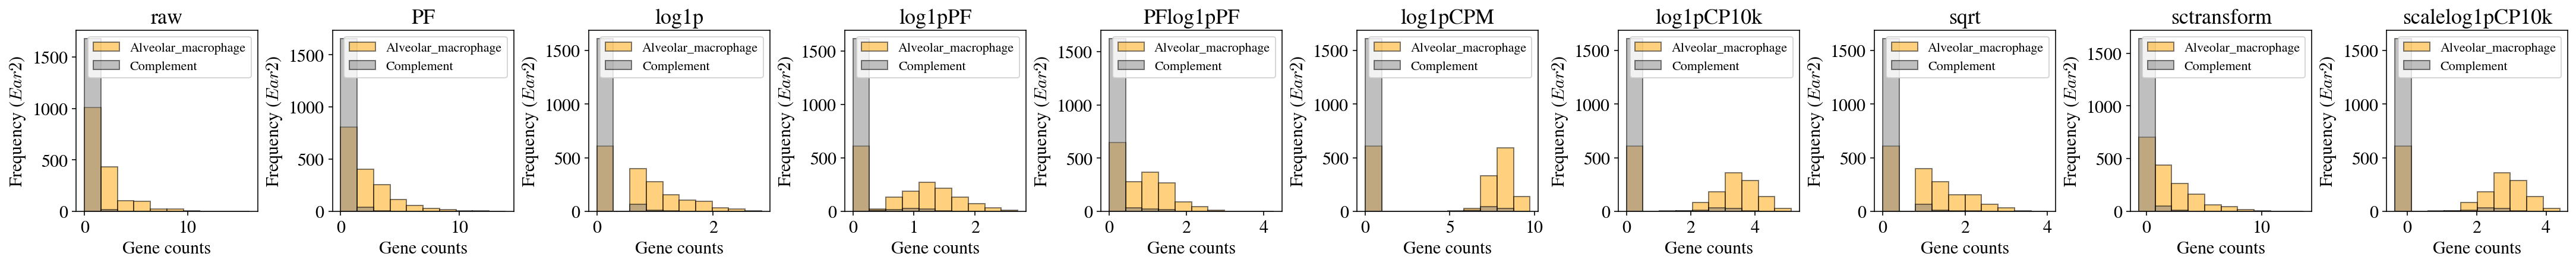

In [87]:
n = len(data.keys())
fig, axs = plt.subplots(figsize=(3 * n, 3), ncols=n, constrained_layout=True)

for ax, (k, m) in zip(axs, data.items()):
    plot_markers(m, k, celltype, gene, ct_mask, gene_mask, downsample_idx, ax)

fig.show()

# Combined marker genes

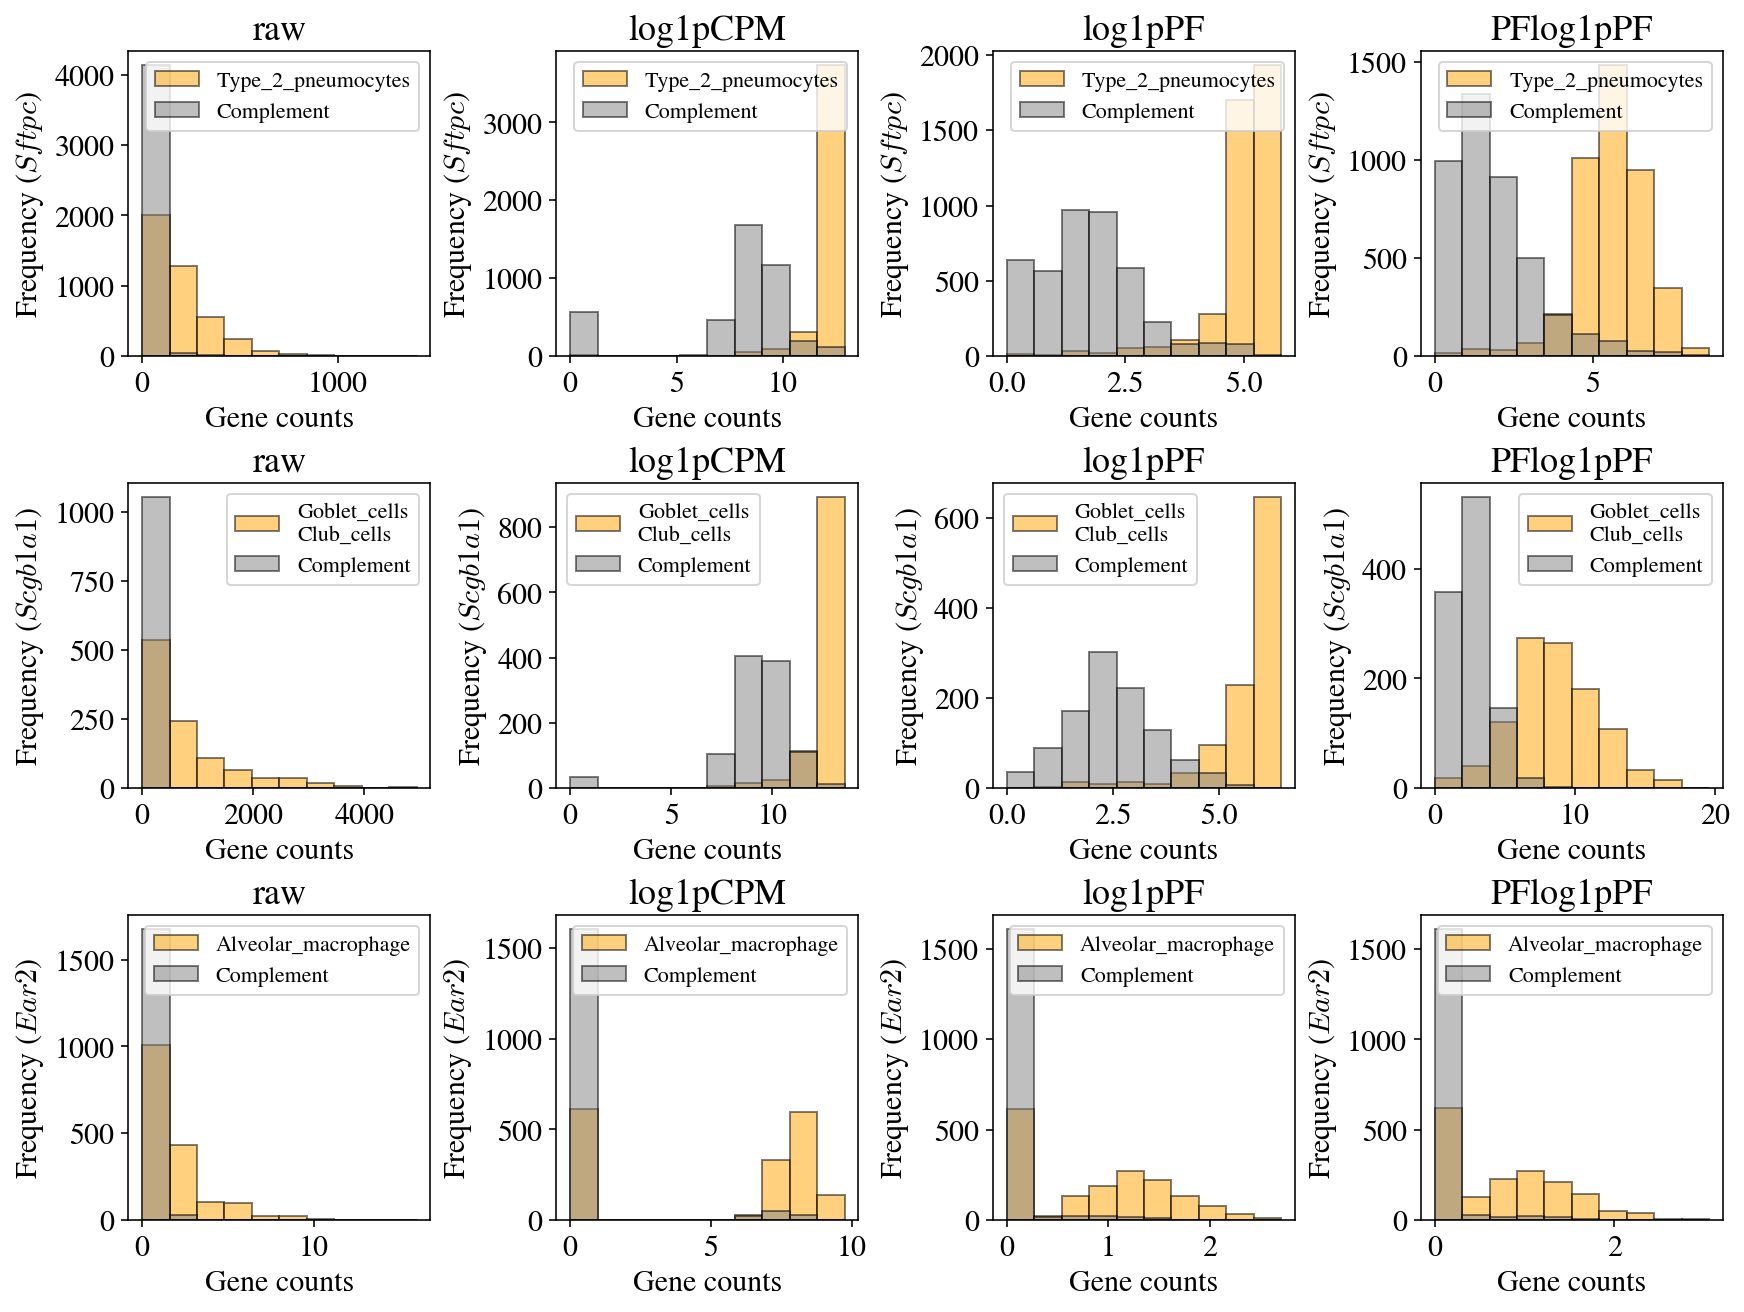

In [88]:
pltlabels = ["raw", "log1pCPM", "log1pPF", "PFlog1pPF"]
n = len(pltlabels)
mg = ["Sftpc", "Scgb1a1", "Ear2"]
m = len(mg)

fig, axes = plt.subplots(
    figsize=(3 * n, 3 * m), ncols=n, nrows=m, constrained_layout=True
)

## First
celltype = "Type_2_pneumocytes"
gene = "Sftpc"

gene_mask = genes == gene
ct_mask = assignments == celltype
size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

axs = axes[0]
for ax, k in zip(axs, pltlabels):
    plot_markers(data[k], k, celltype, gene, ct_mask, gene_mask, downsample_idx, ax)

## Second

celltype1 = "Goblet_cells"
celltype2 = "Club_cells"

ct_mask1 = assignments == celltype1
ct_mask2 = assignments == celltype2

ct_mask = np.logical_or(ct_mask1, ct_mask2)

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

gene = "Scgb1a1"

gene_mask = genes == gene

axs = axes[1]
for ax, k in zip(axs, pltlabels):
    plot_markers(
        data[k],
        k,
        celltype1 + "\n" + celltype2,
        gene,
        ct_mask,
        gene_mask,
        downsample_idx,
        ax,
    )

## third
celltype = "Alveolar_macrophage"
gene = "Ear2"

ct_mask = assignments == celltype
gene_mask = genes == gene

size_t = (ct_mask).sum()
size_c = (~ct_mask).sum()
downsample_idx = np.random.choice(np.arange(size_c), size=size_t, replace=False)

axs = axes[2]
for ax, k in zip(axs, pltlabels):
    plot_markers(data[k], k, celltype, gene, ct_mask, gene_mask, downsample_idx, ax)

base_file_name = "angelidis_2019_celltype_markers"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

In [96]:
def savefig(path):
    parent = os.path.dirname(path)
    basename = os.path.basename(path)
    f, fext = os.path.splitext(basename)

    if not os.path.exists(parent):
        os.makedirs(parent)

    fig.savefig(
        os.path.join(parent, f"{f}.png"),
        facecolor="white",
        transparent=False,
        dpi=300,
        bbox_inches="tight",
    )
    fig.savefig(os.path.join(parent, f"{f}.pdf"), dpi=300, bbox_inches="tight")
    return